In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import math

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig



def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [4]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [5]:
X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [6]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# # Original losses:
# # -------------------
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

In [7]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.2 MB/s eta 0:00:00


In [8]:
import numpy as np


class MNISTDataset:
    """'Bare minimum' class to wrap MNIST numpy arrays into a dataset."""
    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,
                 to01=True, shuffle=True, seed=None):
        """
        Use seed optionally to always get the same shuffling (-> reproducible
        results).
        """
        self.batch_size = batch_size
        self.train_data = train_imgs
        self.train_labels = train_lbs.astype(np.int32)
        self.test_data = test_imgs
        self.test_labels = test_lbls.astype(np.int32)

        if to01:
            # int in [0, 255] -> float in [0, 1]
            self.train_data = self.train_data.astype(np.float32) / 255
            self.test_data = self.test_data.astype(np.float32) / 255

        self.size = self.train_data.shape[0]

        if seed:
            np.random.seed(seed)
        if shuffle:
            self.shuffle_train()
        self.shuffle = shuffle
        self.current_pos = 0

    def next_batch(self):
        """Either gets the next batch, or optionally shuffles and starts a
        new epoch."""
        end_pos = self.current_pos + self.batch_size
        if end_pos < self.size:
            batch = (self.train_data[self.current_pos:end_pos],
                     self.train_labels[self.current_pos:end_pos])
            self.current_pos += self.batch_size
        else:
            # we return what's left (-> possibly smaller batch!) and prepare
            # the start of a new epoch
            # batch = (self.train_data[self.current_pos:self.size],
            #          self.train_labels[self.current_pos:self.size])
            if self.shuffle:
                self.shuffle_train()
            self.current_pos = 0
            end_pos = self.current_pos + self.batch_size
            batch = (self.train_data[self.current_pos:end_pos],
                     self.train_labels[self.current_pos:end_pos])
            self.current_pos += self.batch_size
            # print("Starting new epoch...")
        return batch

    def shuffle_train(self):
        shuffled_inds = np.arange(self.train_data.shape[0])
        np.random.shuffle(shuffled_inds)
        self.train_data = self.train_data[shuffled_inds]
        self.train_labels = self.train_labels[shuffled_inds]

In [9]:
# Alternative losses:
# # -------------------
# D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
# D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
# D_loss = D_loss_real + D_loss_fake
# G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

11490434/11490434 [==============================] - 0s 0us/step


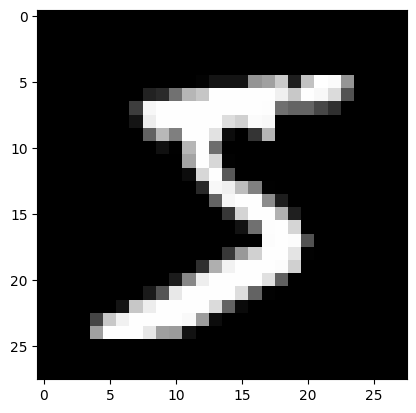

In [10]:

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[0], cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

                    
for it in range(5000):
    X_mb,_ = data.next_batch()
    if X_mb.shape == (96,784):
        print(X_mb.shape)   

In [11]:
def train():
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

    mb_size = 128
    Z_dim = 100
    n_iterations = 100000
    path = "out_org_100k/"

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    if not os.path.exists(path):
        os.makedirs(path)

    i = 0

    for it in range(n_iterations+1):
        if it % 1000 == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

            fig = plot(samples)
            plt.savefig('out_org_100k/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.close(fig)

        X_mb, _ = data.next_batch()


        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

        if math.isnan(D_loss_curr):
            print("oh no loss became nan at iteration",it) 
            return False

        if it % 1000 == 0:
            print('Iter: {}'.format(it))
            print('D loss: {:.4}'. format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print()
    return True


In [12]:
attemps = 0
while not train():
    attemps+=1

print (attemps)

Iter: 0
D loss: 1.417
G_loss: 2.559

Iter: 1000
D loss: 0.003699
G_loss: 9.234

Iter: 2000
D loss: 0.004684
G_loss: 7.188

Iter: 3000
D loss: 0.02898
G_loss: 6.092

Iter: 4000
D loss: 0.09164
G_loss: 5.716

oh no loss became nan at iteration 4559
Iter: 0
D loss: 1.172
G_loss: 2.645

Iter: 1000
D loss: 0.01073
G_loss: 10.88

Iter: 2000
D loss: 0.01719
G_loss: 6.422

Iter: 3000
D loss: 0.06238
G_loss: 5.661

Iter: 4000
D loss: 0.1468
G_loss: 4.752

oh no loss became nan at iteration 4692
Iter: 0
D loss: 1.352
G_loss: 2.32

Iter: 1000
D loss: 0.008014
G_loss: 9.562

Iter: 2000
D loss: 0.03829
G_loss: 5.237

Iter: 3000
D loss: 0.06799
G_loss: 5.364

Iter: 4000
D loss: 0.2036
G_loss: 5.958

oh no loss became nan at iteration 4429
Iter: 0
D loss: 1.968
G_loss: 1.857

Iter: 1000
D loss: 0.01186
G_loss: 11.05

Iter: 2000
D loss: 0.06403
G_loss: 5.27

Iter: 3000
D loss: 0.04806
G_loss: 6.207

Iter: 4000
D loss: 0.08651
G_loss: 5.604

Iter: 5000
D loss: 0.1108
G_loss: 4.852

Iter: 6000
D loss: 0